# Module Four Final Project

For: Trace Political, LLC

By: Jonathan E. Ericksen, JE Consulting

## Background
> Trace Political is a consulting firm that specializes in social media consulting for congressional campaigns. Trace Political has contracted with JE Consulting to run an analysis on ~86K tweets from sitting congressional representatives. The tweets were acquired from May 2018 and are expected to yield valuable insights into the social media behavior and trends from current elected officials. 

## Objective:
The objective for JE Consulting is two fold: 

>- **Objective One: Corpus Analysis**
    - Extract the top 10 most words used within tweets from both Democrat and Republican representatives
    - Extract the total vocab count used in both the Democrat and Republican tweet corpus'
    - Extract words with the highest semantic relation to the following through word vectorization: 
        - Trump
        - Bill
        - Tax
    - Using TextBlob, extract the sentiment rating for Democrat and Republican tweets

>- **Objective Two: Tweet Classification using Neural Networks**
    - In addition to corpus analysis, Trace Political has asked JE Consulting to suss out the feasibility of building a classifier using neural networks that successfully predicts the political party of which the author of an official tweet belongs. In order to be deemed successful, the model must successfully predict political party with 90% accuracy on test data. Should this succeed, Trace Political will further pursue projects related to predictive modeling with natural language processing.

## Question:
> Can a neural network successfully classify political affiliation based on language contained in official tweets from the available dataset?

## Methodology:

> This project is broken down in to two parts. Part One will will address the first objective which is to perform basic analysis of the text corpus contained within tweets from the dataset. Part Two will attempt to model the text data resulting in successful party classification. Part Two will finish with a conclusion based upon the attempted modeling along with recommendations for future work to enhance model performances, et cetera. The sections and sub-sections are outlined in the table of contents below.

## Table of Contents:<a id='top'></a>
### [Obtain](#obtain): 
> - Sourcing the Data
> - Importing Data

### [Part One](#partone)

> - Exploratory Data Analysis 
> - Number of Tweets By Party
> - Common Words by Party
> - Vocab Length
> - Semantic Relationships
> - Sentiment Analysis

### [Part Two](#parttwo)

> - Feature Engineering
    - Data Cleaning
    - Convert Labels to Integers
    - Tokenize Text
    - Padding Input Matrices
    - Train Test Split
> - Modeling
    - LSTM Model One
    - LSTM Model Two
    - LSTM Model Three
    - GRU Model One
    
> **[Conclusions](#conclusion)**

> **[Recommendations](#recommendation)**

> **[Future Work](#futurework)**

------------------------------------------------------------------------------------------------------------------

Before we begin, let's import the necessary libraries for our project: 

In [1]:
import pandas as pd

import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros

import string

import re
import nltk as nlp
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.probability import FreqDist
nlp.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, LSTM, GRU
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool1D, Embedding, Dropout
from keras.preprocessing import text, sequence
from keras import regularizers

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec

from textblob import TextBlob

import warnings; warnings.simplefilter('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathanericksen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.


### Obtain <a id='obtain'></a>

[Back to top](#top)

The data used for this project comes from Kaggle and includes a sampling of ~86k tweets sent from both Democratic and Republican representatives in the U.S. congress during May 2018. The dataset can be found here: https://www.kaggle.com/kapastor/democratvsrepublicantweets 

Let's lod the CSV file from kaggle into a pandas dataframe: 

In [2]:
df = pd.read_csv('ExtractedTweets.csv')

--------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------
# *Part One*<a id='partone'></a>

[Back to top](#top)

### Explatory Data Analysis

We'll begin our exploratory analysis by reviewing the head and tail of the dataset:

In [3]:
display(df.head())
display(df.tail())

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


,Party,Handle,Tweet
86455,Republican,RepTomPrice,Check out my op-ed on need for End Executive O...
86456,Republican,RepTomPrice,"Yesterday, Betty &amp; I had a great time lear..."
86457,Republican,RepTomPrice,We are forever grateful for the service and sa...
86458,Republican,RepTomPrice,Happy first day of school @CobbSchools! #CobbB...
86459,Republican,RepTomPrice,#Zika fears realized in Florida. House GOP act...


Let's confirm there are no null values:

In [4]:
display(df.isnull().sum())

Party     0
Handle    0
Tweet     0
dtype: int64

Check the shape of the dataset:

In [5]:
df.shape

(86460, 3)

And look at the first 5 full tweets: 

In [6]:
display(df['Tweet'][0])
display(df['Tweet'][1])
display(df['Tweet'][2])
display(df['Tweet'][3])
display(df['Tweet'][4])

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L'

'RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…'

'RT @NBCLatino: .@RepDarrenSoto noted that Hurricane Maria has left approximately $90 billion in damages. \n\nCongress has allocated about $18…'

'RT @NALCABPolicy: Meeting with @RepDarrenSoto . Thanks for taking the time to meet with @LatinoLeader ED Marucci Guzman. #NALCABPolicy2018.…'

'RT @Vegalteno: Hurricane season starts on June 1st; Puerto Rico’s readiness...well 🤦🏼\u200d♂️😡😩@Pwr4PuertoRico @RepDarrenSoto @EspaillatNY'

### Number of Tweets by Party

To find the number of tweets in our dataset per party, we'll begin by parsing out the democrat vs. republican tweets:

In [7]:
democrat = df[(df['Party'] == 'Democrat')]
republican = df[(df['Party'] == 'Republican')]

Let's see how many representatives have tweeted during May 2018 by party:

In [8]:
print('Number of representatives using twitter during May 2018 is as follows:')
print()
print('Democrats: {}'.format(democrat['Handle'].nunique()))
print('Republicans: {}'.format(republican['Handle'].nunique()))

Number of representatives using twitter during May 2018 is as follows:

Democrats: 211
Republicans: 222


And the number of tweets by party our dataset contains: 

In [9]:
dem_tweets = democrat['Handle'].count()
rep_tweets = republican['Handle'].count()

print('Number of Democratic tweets:', dem_tweets)
print('Number of Republican tweets:', rep_tweets)

Number of Democratic tweets: 42068
Number of Republican tweets: 44392


Finally, we'll visualize the tweet volumes using the seaborn countplot:

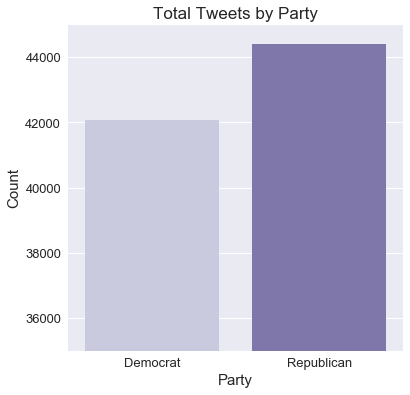

In [10]:
plt.figure(figsize=(6,6))
sns.countplot(x = 'Party', data = df, palette='Purples')

plt.title('Total Tweets by Party', size = 17)
plt.ylabel('Count', size = 15)
plt.xlabel('Party', size = 15)
plt.ylim(35000, 45000)

plt.xticks(size = 13)
plt.yticks(size = 13);

### Common Words by Party

For analyzing common words by party, we'll need to clean the dataset. We'll begin by establishing a list of stopwords that we'll filter from the text data:

In [11]:
stopwords = stopwords.words('english')
stopwords += ['rt', 'u', 'amp', 'w', 'th']
stopwords += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Next, we'll write a for loop that iterates through the parties' respective tweets and cleans them by removing special characters, punctuation, the stopwords listed above, et cetera. The comments in the below indicate what each line of for loop is accomplishing:

In [12]:
democrat_list = []

for d in democrat.Tweet:
    
    d = re.sub(r'http\S+', '', d) # For removing links
    d = re.sub("[^a-zA-Z]", " ", d) # For removing all characters except letters
    d = d.lower() # For converting all words to lowercase
    
    d = nlp.word_tokenize(d) # Tokenizing the words in our corpus
    d = [word for word in d if not word in set(stopwords)] #
    
    lemma = nlp.WordNetLemmatizer() 
    d = [lemma.lemmatize(word) for word in d] # For consolidating multiple words of a single form ('running', 'ran' --> 'run')
    d = " ".join(d)
    
    democrat_list.append(d) # Append the words to our 'democrat_list'

In [13]:
republican_list = []

for r in republican.Tweet:
    
    r = re.sub(r'http\S+', '', r)
    r = re.sub("[^a-zA-Z]", " ", r)
    r = r.lower()
    
    r = nlp.word_tokenize(r)
    r = [word for word in r if not word in set(stopwords)]
   
    lemma=nlp.WordNetLemmatizer()
    r = [lemma.lemmatize(word) for word in r]
    r = " ".join(r)
    
    republican_list.append(r)

Let's view our cleaned democrat and republican tweets: 

In [15]:
democrat_list[:5]

['today senate dems vote savetheinternet proud support similar netneutrality legislation house',
 'winterhavensun winter resident alta vista teacher one several recognized repdarrensoto national teacher apprecia',
 'nbclatino repdarrensoto noted hurricane maria left approximately billion damage congress allocated',
 'nalcabpolicy meeting repdarrensoto thanks taking time meet latinoleader ed marucci guzman nalcabpolicy',
 'vegalteno hurricane season start june st puerto rico readiness well pwr puertorico repdarrensoto espaillatny']

In [16]:
republican_list[:5]

['wastefulwednesday today introduced bill would eliminate global climate change initiative gc',
 'today honored heroic men woman law enforcement lost life line duty nati',
 'congressmanraja last week repralphnorman hosted briefing economic benefit solar energy production',
 'tegacaypd chief parker thankful receive recognition repralphnorman delivered mayor davidloneal national police',
 'visited sc highway patrol bring cupcake thank service honor']

One way to get a count of the total number of cleaned words in our corpus by party is to .split() the list of words in our lists and replace the commas with spaces:

In [17]:
democrat_tweets = str(democrat_list).split()
republican_tweets = str(republican_list).split()

democrat_tweets = [word.replace("'","") for word in democrat_tweets]
democrat_tweets = [word.replace("[", "") for word in democrat_tweets]
democrat_tweets = [word.replace("]","") for word in democrat_tweets]
democrat_tweets = [word.replace(",", "") for word in democrat_tweets]

republican_tweets = [word.replace("'","") for word in republican_tweets]
republican_tweets = [word.replace("[", "") for word in republican_tweets]
republican_tweets = [word.replace("]","") for word in republican_tweets]
republican_tweets = [word.replace(",", "") for word in republican_tweets]

In [18]:
print("Total words in Democratic tweets:",len(democrat_tweets))
print("Total words in Republican tweets:",len(republican_tweets))

Total words in Democratic tweets: 443138
Total words in Republican tweets: 457293


In order to extract the most common words used by republican and democratic representatives, we'll build a frequency distribution that extracts the most common words used: 

In [19]:
fdist_democrat = FreqDist(democrat_tweets)
fdist_republican = FreqDist(republican_tweets)

In [46]:
print('Most common words used by Democrats:')
display(fdist_democrat)

print('-'*100)

print('Most common words used by Republicans:')
display(fdist_republican)

Most common words used by Democrats:


FreqDist({'today': 3850, 'trump': 2502, 'american': 2053, 'year': 1835, 'thank': 1777, 'family': 1694, 'great': 1676, 'student': 1660, 'day': 1571, 'congress': 1518, ...})

----------------------------------------------------------------------------------------------------
Most common words used by Republicans:


FreqDist({'today': 4883, 'tax': 2885, 'great': 2876, 'house': 2382, 'bill': 2379, 'american': 2241, 'thank': 2118, 'year': 1961, 'day': 1887, 'act': 1820, ...})

Let's create a sorted dataframe for the top ten words used for both democrats and republicans:

In [52]:
dem = pd.DataFrame(list(fdist_democrat.items()), 
                   columns = ["Word","Frequency"])
dem_sorted = dem.sort_values(by = ['Frequency'], 
                             ascending=False)
dem_sorted.head(10)

,Word,Frequency
0,today,3850
80,trump,2502
89,american,2053
108,year,1835
56,thank,1777
197,family,1694
92,great,1676
195,student,1660
465,day,1571
31,congress,1518


In [54]:
rep = pd.DataFrame(list(fdist_republican.items()),
                   columns = ["Word","Frequency"])
rep_sorted = re.sort_values(['Frequency'], 
                            ascending=False)
rep_sorted.head(10)

,Word,Frequency
1,today,4883
102,tax,2885
99,great,2876
188,house,2382
3,bill,2379
71,american,2241
50,thank,2118
135,year,1961
100,day,1887
385,act,1820


And finally we'll plot the most frequent words by party:

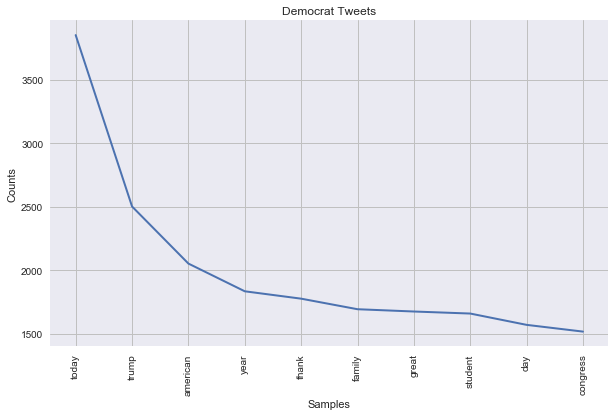

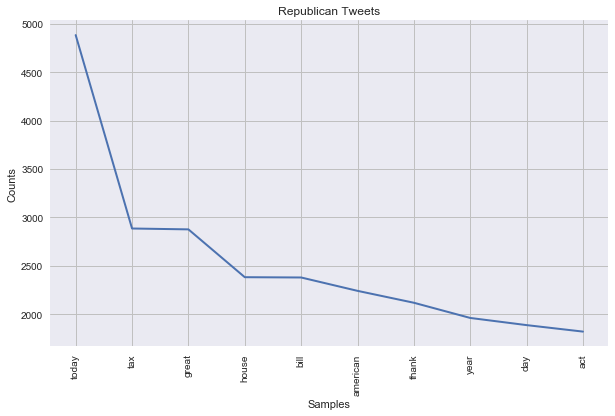

In [38]:
plt.subplots(figsize = (10,6))
fdist_democrat.plot(10, title = "Democrat Tweets")


plt.subplots(figsize = (10,6))
fdist_republican.plot(10, title="Republican Tweets");

### Vocab Length

We're going to recover the total vocab for both parties in this brief section followed by visualizing the differences in their respective twitter lexicons:

In [39]:
dem_vocab = set(word for text in democrat_list for word in text.split(" "))
dem_total_vocab = len(dem_vocab)
print(dem_total_vocab)

35462


In [40]:
rep_vocab = set(word for text in republican_list for word in text.split(" "))
rep_total_vocab = len(rep_vocab)
print(rep_total_vocab)

33086


Let's plot the total vocab by party:

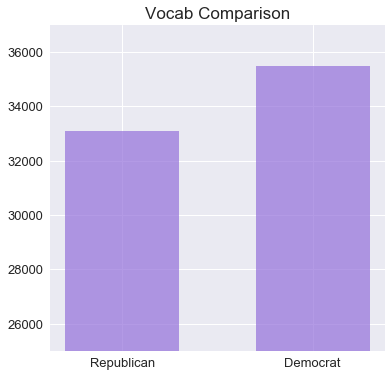

In [41]:
plt.figure(figsize=(6,6))

y = (rep_total_vocab, dem_total_vocab,)
x = ('Republican', 'Democrat')

plt.bar(x,y, width = .6, color = 'mediumpurple', align = "center", alpha = .7)
plt.title('Vocab Comparison', size = 17)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.ylim(25000, 37000)

plt.show();

### Semantic Relationships

For this part of our analysis, we're going to extract the semantic relationships between words in our democratic and republican corpus'. We'll do this by training a Word2Vec neural network which establishes the relationships between words via a vector space.

***Democrats***

We'll work through training our embedding model with the democratic corpus followed by the republican corpus. Let's start by tokenizing the text:

In [55]:
dem_tokenized_text = [text.split(" ") for text in democrat_list]

Next we'll train the democrat Word2Vec embedding model:

In [56]:
dem_embedding = Word2Vec(sentences = dem_tokenized_text, size=30)

W0819 11:05:06.366819 4560319936 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance


Let's store our word vectors in a variable X_dem:

In [57]:
X_dem = dem_embedding[dem_embedding.wv.vocab]
X_dem[:1]

array([[-1.4332391 , -0.02321698, -0.2300342 , -0.35703605,  0.25321218,
        -0.84835726,  1.4376367 ,  1.6265154 ,  0.50173956,  0.45448986,
         2.2407904 ,  0.8057655 , -1.5956748 , -0.7114798 , -1.1039497 ,
        -0.38431588,  0.46402666,  0.06003074,  1.1396391 ,  0.6626816 ,
        -0.08829408, -0.31921214,  0.4514533 ,  0.36162245, -0.15818779,
        -0.521039  , -0.5220027 , -0.34021884, -1.0684534 ,  0.6229236 ]],
      dtype=float32)

In order to plot the words in a vector space, we'll need to reduce the number of dimensions to two. We'll do this using principle component analysis (PCA):

In [59]:
pca = PCA(n_components=2)
X_dem_fitted = pca.fit_transform(X_dem)

And store the democrat vocab in a words_dem variable:

In [61]:
words_dem = list(dem_embedding.wv.vocab)

Next we'll define some functions we'll use to print the positive and negative relationships to the target word followed plotting these words in a vector space:

In [64]:
def dem_similar_words_positive(word):
    
    words_to_plot = [word] + [w[0] for w in dem_embedding.wv.most_similar(positive = word)]
    indices = [words_dem.index(word_to_plot) for word_to_plot in words_to_plot]
   
    plt.figure(figsize=(8,6))
    for index, word in zip(indices, words_to_plot):
        
        vec = X_dem_fitted[index]
        
        plt.scatter(vec[0], vec[1], c = 'mediumpurple', s = 200, alpha=0.5)
        plt.annotate(word, vec + [0.15, 0], fontsize = 14)

    print('Similar words with positive semantic relationship:')
    display(words_to_plot)
    plt.show()

In [65]:
def dem_similar_words_negative(word):
    
    words_to_plot = [word] + [w[0] for w in dem_embedding.wv.most_similar(negative = word)]
    indices = [words_dem.index(word_to_plot) for word_to_plot in words_to_plot]
   
    plt.figure(figsize=(8,6))
    for index, word in zip(indices, words_to_plot):
        
        vec = X_dem_fitted[index]
        
        plt.scatter(vec[0], vec[1], c = 'mediumpurple', s = 200, alpha=0.5)
        plt.annotate(word, vec+[0.15, 0], fontsize = 14)

    print('Similar words with positive semantic relationship:')
    display(words_to_plot)
    plt.show()

Now we can run our functions using the target words outlined in the project overview. We'll start with 'trump':

Similar words with positive semantic relationship:


['trump',
 'realdonaldtrump',
 'obama',
 'decision',
 'mr',
 'decis',
 'withdraw',
 'potus',
 'iran',
 'potentia',
 'russian']

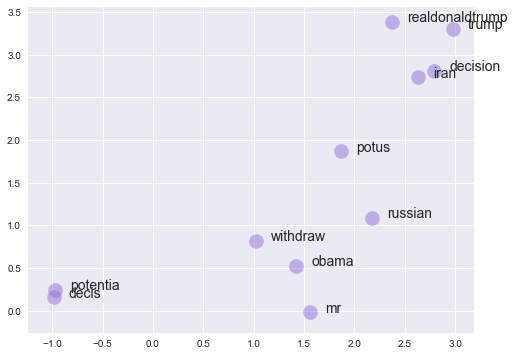

In [66]:
dem_similar_words_positive('trump')

In [69]:
dem_similar_words_negative('trump')

KeyError: "word 't' not in vocabulary"

The next word in 'bill:

Similar words with positive semantic relationship:


['bill',
 'amendment',
 'farm',
 'omnibus',
 'passed',
 'introduced',
 'legislation',
 'faa',
 'farmbill',
 'reauthorization',
 'hr']

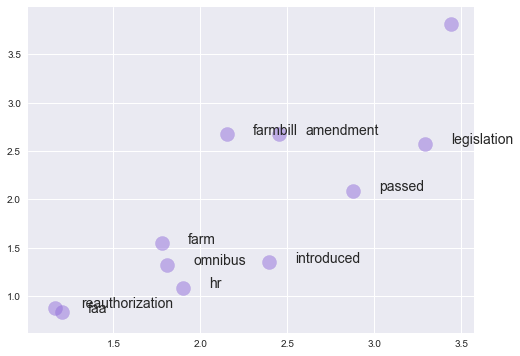

In [70]:
dem_similar_words_positive('bill')

In [71]:
dem_similar_words_negative('bill')

KeyError: "word 'i' not in vocabulary"

And finally, the word 'tax':

Similar words with positive semantic relationship:


['tax',
 'goptaxscam',
 'corporation',
 'trillion',
 'wealthy',
 'inste',
 'bre',
 'deficit',
 'break',
 'millionaire',
 'giveaway']

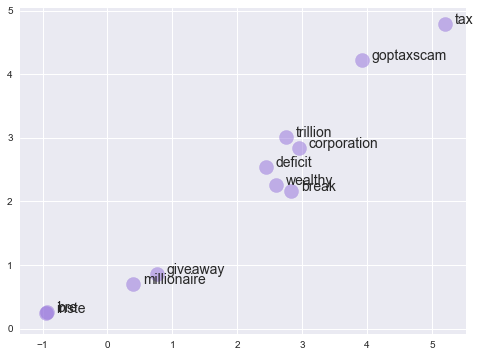

In [72]:
dem_similar_words_positive('tax')

In [73]:
dem_similar_words_negative('tax')

KeyError: "word 't' not in vocabulary"

***Republicans***

We'll follow the same steps for the republican tweet corpus as above with the democrat tweet corpus:

In [74]:
rep_tokenized_text = [text.split(" ") for text in republican_list]

In [75]:
rep_embedding = Word2Vec(sentences = rep_tokenized_text, size=30)

W0819 11:18:03.636281 4560319936 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance


In [78]:
X_rep = rep_embedding[rep_embedding.wv.vocab]
X_rep[:1]

array([[-1.7019881 ,  0.86577433,  0.58782357,  0.49181423,  0.74140817,
        -0.6638464 ,  0.25284913,  0.3115484 , -0.04441207,  0.9149143 ,
         1.6874301 ,  1.1493967 , -1.0559144 , -0.22209908, -1.1589454 ,
        -0.17086521, -0.3484325 , -0.39713392,  1.1889472 ,  0.98132133,
         0.25248274,  0.02607881,  0.16545753,  0.4747712 ,  0.23586151,
         0.13168404, -0.27666354, -0.494892  , -0.8814896 ,  0.8726118 ]],
      dtype=float32)

In [79]:
pca = PCA(n_components=2)
X_rep_fitted = pca.fit_transform(X_rep)

In [81]:
words_rep = list(rep_embedding.wv.vocab)

In [82]:
def rep_similar_words_positive(word):
    
    words_to_plot = [word] + [w[0] for w in rep_embedding.wv.most_similar(positive = word)]
    indices = [words_rep.index(word_to_plot) for word_to_plot in words_to_plot]
   
    plt.figure(figsize=(8,6))
    
    for index, word in zip(indices, words_to_plot):
        
        vec = X_rep_fitted[index]
       
        plt.scatter(vec[0], vec[1], c = 'mediumpurple', s = 200, alpha=0.5)
        plt.annotate(word, vec+[0.15, 0], fontsize = 14)

    print('Similar words with positive semantic relationship:')
    display(words_to_plot)
    plt.show()

In [83]:
def rep_similar_words_negative(word):
    
    words_to_plot = [word] + [w[0] for w in rep_embedding.wv.most_similar(negative = 'word')]
    indices = [words_rep.index(word_to_plot) for word_to_plot in words_to_plot]
   
    plt.figure(figsize=(8,6))
    
    for index, word in zip(indices, words_to_plot):
       
        vec = X_rep_fitted[index]
        
        plt.scatter(vec[0], vec[1], c = 'mediumpurple', s = 200, alpha=0.5)
        plt.annotate(word, vec+[0.15, 0], fontsize = 14)

    print('Similar words with negative semantic relationship:')
    display(words_to_plot)
    plt.show()

With our republican functions established, let's analyze the same target words. We'll start with 'trump':

Similar words with positive semantic relationship:


['trump',
 'obama',
 'realdonaldtrump',
 'decision',
 'desk',
 'deal',
 'iran',
 'russia',
 'administration',
 'applaud',
 'macron']

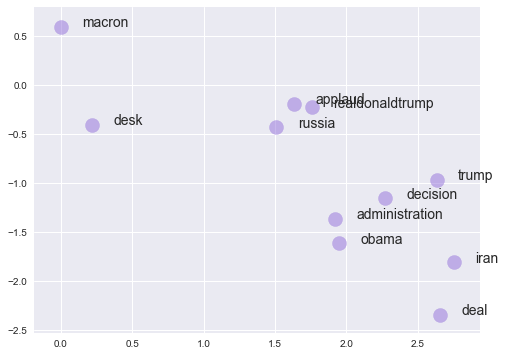

In [84]:
rep_similar_words_positive('trump')

In [85]:
rep_similar_words_negative('trump')

KeyError: "word 'w' not in vocabulary"

And 'bill':

Similar words with positive semantic relationship:


['bill',
 'legislation',
 'hr',
 'introduced',
 'included',
 'act',
 'readit',
 'volcker',
 'pas',
 'includes',
 'reauthorization']

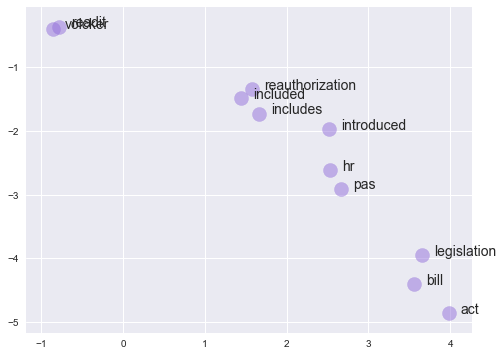

In [86]:
rep_similar_words_positive('bill')

In [87]:
rep_similar_words_negative('bill')

KeyError: "word 'w' not in vocabulary"

And finally, 'tax':

Similar words with positive semantic relationship:


['tax',
 'taxreformtuesday',
 'implemented',
 'broken',
 'standard',
 'burdensome',
 'result',
 'outdated',
 'unemployment',
 'verizon',
 'paycheck']

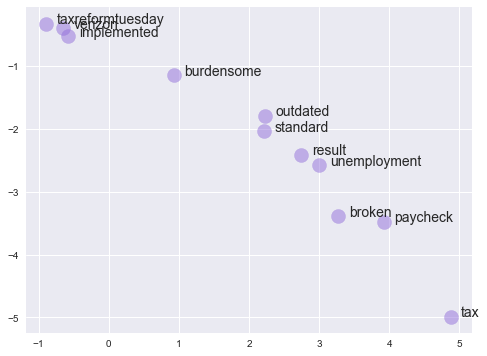

In [88]:
rep_similar_words_positive('tax')

In [89]:
rep_similar_words_negative('tax')

KeyError: "word 'w' not in vocabulary"

### Sentiment Analysis

This section will focus on the overall sentiment exuded by tweets from each party. We'll calculate our sentiment scores using TextBlob:

In [77]:
democratblob = TextBlob(str(democrat_tweets))
republicanblob = TextBlob(str(republican_tweets))

In [78]:
dem_sentiment = democratblob.sentiment[0]
print('Democratic sentiment score:', dem_sentiment)

rep_sentiment = republicanblob.sentiment[0]
print('Republican sentiment score:', rep_sentiment)

Democratic sentiment score: 0.16536069955855845
Republican sentiment score: 0.19836825482009132


Perhaps not surprisingly, democrats in congress exude a slightly more negative tone as a large portion of their content is likely aimed at highlighting the negative consequences of the republican lead majority at the time of data capture. 

Let's do a quick visual side by side comparison of the sentiment:

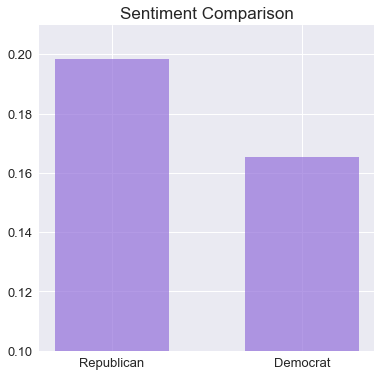

In [79]:
plt.figure(figsize=(6,6))

y = (rep_sentiment, dem_sentiment)
x = ('Republican', 'Democrat')

plt.bar(x,y, width = .6, color = 'mediumpurple', align = "center", alpha = .7)
plt.title('Sentiment Comparison', size = 17)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.ylim(.1,.21)

plt.show();

--------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------

# *Part Two<a id='parttwo'></a>*
[Back to top](#top)

Part two of this project will focus on party classification of our tweet dataset using a neural networks. We'll begin with feature engineering followed attempting to model our data using LSTM and GRU networks. Producing a model that does not exhibit over fitting while generating an accuracy score of 90% or better is the objective here.

### Feature Engineering
We'll begin this section by re-importing our dataset:

In [2]:
df = pd.read_csv('ExtractedTweets.csv')
df.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


**Data Cleaning**

Next, we'll generate our stopwords list for cleaning the tweet text: 

In [3]:
stopwords = stopwords.words('english')
stopwords += ['rt', 'u', 'amp', 'w', 'th']
stopwords += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

We'll clean the tweets using a for loop and a combination of regex and our stopwords list above. The output from this cleaning loop has subsequently been saved to a json file in our repo from running the cleaning loop previously: 

In [6]:
clean_tweet = []

for w in df.Tweet:
    
    w = re.sub(r'http\S+', '', w) #remove links
    w = re.sub("[^a-zA-Z]", " ", w) #remove all characters except letters
    w = w.lower() #convert all words to lowercase
    
    w = nlp.word_tokenize(w) #split sentences into word
    w = [word for word in w if not word in set(stopwords)] #add to stopwords list if unnecessary words.
    
    lemma = nlp.WordNetLemmatizer() 
    w = [lemma.lemmatize(word) for word in w] #identify the correct form of the word in the dictionary
    
    w = " ".join(w)
    
    clean_tweet.append(w) #append words to list

Here's where we've saved the cleaned tweets previously:

In [ ]:
df["clean_tweet"] = clean_tweet

df.to_json("cleaned_tweet_data.json")

Below we'll call our clean tweet json file for modeling purposes:

In [97]:
df = pd.read_json("cleaned_tweet_data.json")
df.head()

,Party,Handle,Tweet,clean_tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senate dems vote savetheinternet proud s...
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winterhavensun winter resident alta vista teac...
10,Democrat,RepDarrenSoto,RT @AllSaints_FL: Zhihan (John)'s art received...,allsaints fl zhihan john art received award ye...
100,Democrat,RepDarrenSoto,Thanks to @FL_WildCorridor @CarltonWard @JoeGu...,thanks fl wildcorridor carltonward joeguthrie ...
1000,Democrat,RepBarragan,Very cool. Congrats Luz on breaking a barrier ...,cool congrats luz breaking barrier baseball li...


Next we'll compare the original tweets to the now cleaned text to ensure all unnecessary text characters have been removed: 

In [84]:
display(df['Tweet'][0])
display(df['Tweet'][1])
display(df['Tweet'][2])
display(df['Tweet'][3])
display(df['Tweet'][4])

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L'

'RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…'

'RT @NBCLatino: .@RepDarrenSoto noted that Hurricane Maria has left approximately $90 billion in damages. \n\nCongress has allocated about $18…'

'RT @NALCABPolicy: Meeting with @RepDarrenSoto . Thanks for taking the time to meet with @LatinoLeader ED Marucci Guzman. #NALCABPolicy2018.…'

'RT @Vegalteno: Hurricane season starts on June 1st; Puerto Rico’s readiness...well 🤦🏼\u200d♂️😡😩@Pwr4PuertoRico @RepDarrenSoto @EspaillatNY'

In [85]:
clean_tweet = df.clean_tweet

display(clean_tweet[0])
display(clean_tweet[1])
display(clean_tweet[2])
display(clean_tweet[3])
display(clean_tweet[4])

'today senate dems vote savetheinternet proud support similar netneutrality legislation house'

'winterhavensun winter resident alta vista teacher one several recognized repdarrensoto national teacher apprecia'

'nbclatino repdarrensoto noted hurricane maria left approximately billion damage congress allocated'

'nalcabpolicy meeting repdarrensoto thanks taking time meet latinoleader ed marucci guzman nalcabpolicy'

'vegalteno hurricane season start june st puerto rico readiness well pwr puertorico repdarrensoto espaillatny'

**Convert Labels to Integers**

Now that our text data is cleaned, we'll need to convert our labels into digits so we can run them through our models. For our data, we'll make democrat tweets a 1 and republican tweets a 0:

In [98]:
labels = [1 if p == 'Democrat' else 0 for p in df.Party]
labels = np.array(labels)
labels.shape

(86460,)

**Tokenize Text**

Next we'll tokenize the text using NLTK:

In [99]:
tokenizer = text.Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(list(df["clean_tweet"]))

list_tokenized_train = tokenizer.texts_to_sequences(df["clean_tweet"])

**Padding**

In order to feed our tokenized tweets into a model with similar matrix sizes, we'll need to pad the end of each matrix is zeros. Doing so creates matrices with an equal length of 40 integers:

In [100]:
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=40, padding='post')
display(X_t[1])
print()
print('Tweet matrix shape:',X_t.shape)

array([15041,  1716,   402, 15042,  4455,   241,    23,   818,  1121,
        1555,    39,   241, 15043,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)


Tweet matrix shape: (86460, 40)


**Train Test Split**

We'll split our data using the train_test_split method from sklearn with 20% as the test set and 80% as the train set:

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_t, labels, test_size=0.20, random_state=42)

And view our X train and Y train shapes:

In [102]:
X_train.shape

(69168, 40)

In [103]:
y_train.shape

(69168,)

------------------------------------------------------------------------------------------------------------------
### Modeling

For the modeling portion, we're going to run two different RNNs: LSTM and GRU models. The intent is to identify the best model in terms of accuracy scores on the test set while exhibiting no signs of over fitting.

**LSTM Model One**

We'll start by establishing the architecture of our first LSTM model. This model will serve as our baseline model:

In [47]:
lstm_model_one = Sequential()

lstm_model_one.add(Embedding(20000, 128, input_length=40)) # embedding size of 20000 so we use only the 20000 most used words in our corpus

lstm_model_one.add(LSTM(50, return_sequences=True))

lstm_model_one.add(GlobalMaxPool1D()) # so the model uses a maxpool operation across all weights in the recurrent layer

lstm_model_one.add(Dense(50, activation='relu')) # layer of 50 with activation set to relu

lstm_model_one.add(Dense(2, activation='sigmoid')) # output layer activation set to sigmoid for binary classification

Let's compile our model using sparse_categorical_crossentropy as our loss function, 'adam' as our optimizer, and accuracy as our scoring metric: 

In [48]:
lstm_model_one.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

And review the overall architecture: 

In [14]:
lstm_model_one.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 50)            35800     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 2,598,452
Trainable params: 2,598,452
Non-trainable params: 0
_________________________________________________________________


We'll fit our model using a batch size of 128, 6 epochs, and a validation split of 20%:

In [49]:
LSTM_one_history = lstm_model_one.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 55334 samples, validate on 13834 samples
Epoch 1/6
55334/55334 [==============================] - 54s 970us/step - loss: 0.5060 - acc: 0.7335 - val_loss: 0.4278 - val_acc: 0.7882
Epoch 2/6
55334/55334 [==============================] - 50s 900us/step - loss: 0.3445 - acc: 0.8396 - val_loss: 0.4309 - val_acc: 0.7941
Epoch 3/6
55334/55334 [==============================] - 48s 876us/step - loss: 0.2699 - acc: 0.8744 - val_loss: 0.4661 - val_acc: 0.7919
Epoch 4/6
55334/55334 [==============================] - 47s 850us/step - loss: 0.2135 - acc: 0.9032 - val_loss: 0.5513 - val_acc: 0.7875
Epoch 5/6
55334/55334 [==============================] - 46s 834us/step - loss: 0.1622 - acc: 0.9280 - val_loss: 0.6328 - val_acc: 0.7847
Epoch 6/6
55334/55334 [==============================] - 50s 907us/step - loss: 0.1203 - acc: 0.9482 - val_loss: 0.7418 - val_acc: 0.7792


Let's plot the accuracy and loss for both the training and validation set:

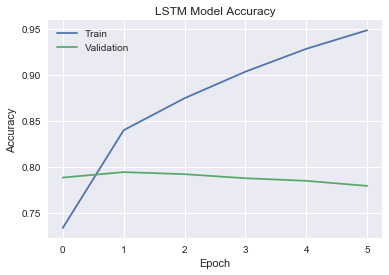

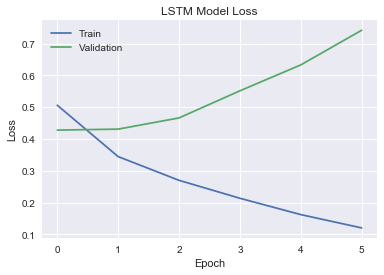

In [50]:
plt.plot(LSTM_one_history.history['acc'])
plt.plot(LSTM_one_history.history['val_acc'])

plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

plt.plot(LSTM_one_history.history['loss'])
plt.plot(LSTM_one_history.history['val_loss'])

plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

Finally, let's see how our model scores on our test set:

In [17]:
score = lstm_model_one.evaluate(X_test, y_test, verbose=1)

17292/17292 [==============================] - 5s 279us/step


In [18]:
print("Test Accuracy:", score[1])

Test Accuracy: 0.7809391626185519


**LSTM Model One Observations**

Our first attempt at training an LSTM model resulted in clear over fitting. This is apparent by the spread between our training and testing accuracy scores: ~94% for the training set and ~78% for the testing set. 

Further, for each epoch beyond the second one, the spread in our training and test accuracy score continued to widen.

Last, our test accuracy score of ~78% means we are far from our target accuracy of 90% in order to deem the model successful.


**LSTM Model Two**

For this model, we'll follow the same steps as before. Changes in our approach from the last model will be outlined as we go. 

The architecture of this model will include a few changes in an attempt to limit over fitting:

- Include L2 regularization
- Include dropout layers
- Limit the size of our dense layers to 16 neurons from 50 neurons

In [104]:
lstm_model_two = Sequential()

lstm_model_two.add(Embedding(20000, 128, input_length=40))

lstm_model_two.add(LSTM(50, return_sequences=True))

lstm_model_two.add(GlobalMaxPool1D())

lstm_model_two.add(Dropout(0.5)) # Adding dropout layers to reduce overfitting

lstm_model_two.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu')) # Reduce neurons in dense layer to 16 while adding L2 regularization

lstm_model_two.add(Dropout(0.5))

lstm_model_two.add(Dense(2, activation='sigmoid')) 

We'll use the same hyperparameters as before:

In [105]:
lstm_model_two.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [106]:
lstm_model_two.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 128)           2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 50)            35800     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                816       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total para

In a final attempt to limit over fitting, we'll increase our validation split to 40% of the training data:

In [108]:
LSTM_two_history = lstm_model_two.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.4)

Train on 41500 samples, validate on 27668 samples
Epoch 1/6
41500/41500 [==============================] - 39s 934us/step - loss: 0.5140 - acc: 0.7715 - val_loss: 0.4649 - val_acc: 0.7804
Epoch 2/6
41500/41500 [==============================] - 38s 924us/step - loss: 0.4011 - acc: 0.8352 - val_loss: 0.4610 - val_acc: 0.7839
Epoch 3/6
41500/41500 [==============================] - 45s 1ms/step - loss: 0.3368 - acc: 0.8638 - val_loss: 0.5010 - val_acc: 0.7823
Epoch 4/6
41500/41500 [==============================] - 36s 869us/step - loss: 0.2865 - acc: 0.8842 - val_loss: 0.5797 - val_acc: 0.7810
Epoch 5/6
41500/41500 [==============================] - 37s 899us/step - loss: 0.2480 - acc: 0.9011 - val_loss: 0.6219 - val_acc: 0.7803
Epoch 6/6
41500/41500 [==============================] - 39s 941us/step - loss: 0.2160 - acc: 0.9153 - val_loss: 0.7951 - val_acc: 0.7781


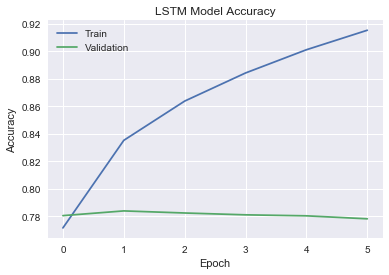

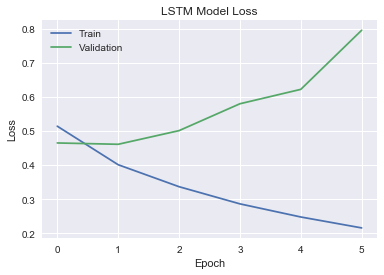

In [109]:
plt.plot(LSTM_two_history.history['acc'])
plt.plot(LSTM_two_history.history['val_acc'])

plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

plt.plot(LSTM_two_history.history['loss'])
plt.plot(LSTM_two_history.history['val_loss'])

plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

In [110]:
score = lstm_model_two.evaluate(X_test, y_test, verbose=1)


17292/17292 [==============================] - 5s 310us/step


In [111]:
print("Test Accuracy:", score[1])

Test Accuracy: 0.7796090677632189


**LSTM Model Two Observations**

Our attempts to limit over fitting produced some positive results, albeit not enough. The spread in training vs. testing accuracy was reduced from a ~16% spread in our first model to a ~12% spread in our second model. 

**LSTM Model Three**

Based on the two models above, our final attempt with an LSTM model will include the same a hyperparameters and architecture as with model two, however, this attempt will limit the number of epochs for training our model to two.

We'll also change our L2 regularization parameter from .001 to .01:

In [26]:
lstm_model_three = Sequential()

lstm_model_three.add(Embedding(20000, 128, input_length=40))

lstm_model_three.add(LSTM(50, return_sequences=True))

lstm_model_three.add(GlobalMaxPool1D())

lstm_model_three.add(Dropout(0.5)) # Adding dropout layers to reduce overfitting

lstm_model_three.add(Dense(16, kernel_regularizer=regularizers.l2(0.01), activation='relu')) # Reduce neurons in dense layer to 16 while adding L2 regularization

lstm_model_three.add(Dropout(0.5))

lstm_model_three.add(Dense(2, activation='sigmoid')) 

In [27]:
lstm_model_three.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [28]:
lstm_model_three.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 128)           2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 50)            35800     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                816       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total para

For the parameters on this model, we're going to reduce our validation split to 10% of the training data. Doing so will offer more data from training given we're only running two epochs with a dense layer of 16 neurons:

In [29]:
LSTM_three_history = lstm_model_two.fit(X_train, y_train, batch_size = 128, epochs = 2, verbose=1, validation_split=0.1)

Train on 62251 samples, validate on 6917 samples
Epoch 1/2
62251/62251 [==============================] - 75s 1ms/step - loss: 0.3311 - acc: 0.8675 - val_loss: 0.4941 - val_acc: 0.7784
Epoch 2/2
62251/62251 [==============================] - 62s 1ms/step - loss: 0.2708 - acc: 0.8900 - val_loss: 0.5782 - val_acc: 0.7810


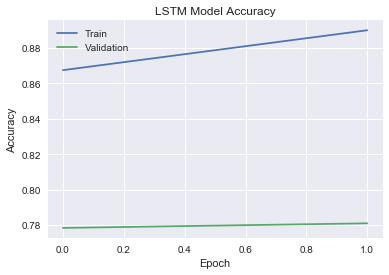

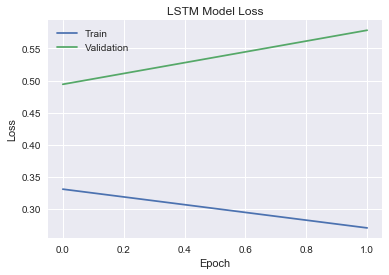

In [32]:
plt.plot(LSTM_three_history.history['acc'])
plt.plot(LSTM_three_history.history['val_acc'])

plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

plt.plot(LSTM_three_history.history['loss'])
plt.plot(LSTM_three_history.history['val_loss'])

plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

In [33]:
score = lstm_model_three.evaluate(X_test, y_test, verbose=1)

17292/17292 [==============================] - 5s 269us/step


In [34]:
print("Test Accuracy:", score[1])

Test Accuracy: 0.4861207494657403


**LSTM Model Three Observations**

Our attempts to limit overfitting while maintaining a decent accuracy score with an LSTM model seems to have come up short. Our final attempt with an LSTM model using only two training epochs did not limit over fitting and produced a test accuracy score of ~49%. This means our model third model produced a mere coin flip result when it comes to classifying political party by tweet text. 

**GRU Model One**

In a further attempt to increase accuracy scores we're going to run a GRU model. We'll use the same architecture and hyperparameters as our second LSTM model with the only difference being our dense layer will include 50 neurons vs. 16:

In [40]:
gru_model_one = Sequential()

gru_model_one.add(Embedding(20000, 128))

gru_model_one.add(GRU(50, return_sequences=True))

gru_model_one.add(GlobalMaxPool1D())

gru_model_one.add(Dropout(0.5))

gru_model_one.add(Dense(50, kernel_regularizer=regularizers.l2(0.001), activation='relu'))

gru_model_one.add(Dropout(0.5))

gru_model_one.add(Dense(2, activation='sigmoid'))

In [41]:
gru_model_one.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
gru_model_one.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_2 (GRU)                  (None, None, 50)          26850     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 102       
Total para

In [43]:
GRU_history_one = gru_model_one.fit(X_train, y_train, epochs=6, batch_size=128, validation_split=0.2)

Train on 55334 samples, validate on 13834 samples
Epoch 1/6
55334/55334 [==============================] - 49s 891us/step - loss: 0.5606 - acc: 0.7079 - val_loss: 0.4544 - val_acc: 0.7805
Epoch 2/6
55334/55334 [==============================] - 55s 998us/step - loss: 0.3844 - acc: 0.8306 - val_loss: 0.4237 - val_acc: 0.7964
Epoch 3/6
55334/55334 [==============================] - 56s 1ms/step - loss: 0.3128 - acc: 0.8639 - val_loss: 0.4536 - val_acc: 0.7933
Epoch 4/6
55334/55334 [==============================] - 47s 856us/step - loss: 0.2655 - acc: 0.8854 - val_loss: 0.4917 - val_acc: 0.7923
Epoch 5/6
55334/55334 [==============================] - 55s 995us/step - loss: 0.2310 - acc: 0.8982 - val_loss: 0.5379 - val_acc: 0.7837
Epoch 6/6
55334/55334 [==============================] - 47s 858us/step - loss: 0.2056 - acc: 0.9103 - val_loss: 0.6170 - val_acc: 0.7824


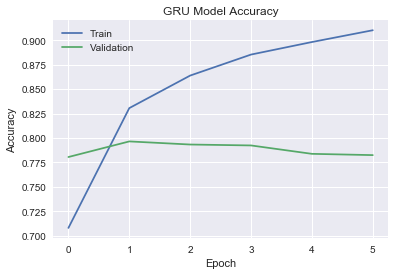

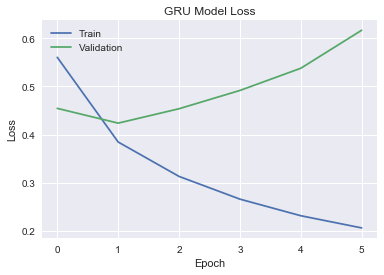

In [44]:
plt.plot(GRU_history_one.history['acc'])
plt.plot(GRU_history_one.history['val_acc'])

plt.title('GRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

plt.plot(GRU_history_one.history['loss'])
plt.plot(GRU_history_one.history['val_loss'])

plt.title('GRU Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

In [45]:
score = gru_model_one.evaluate(X_test, y_test, verbose=1)

17292/17292 [==============================] - 4s 214us/step


In [46]:
print("Test Accuracy:", score[1])

Test Accuracy: 0.7892667129170473


**GRU Model One Observations**

It appears once again that we have struggled to reduce any signs of over fitting. However, the spread between our test and train accuracy score was similar to that of our LSTM Model Two. 

------------------------------------------------------------------------------------------------------------------
## Conclusion <a id='conclusion'></a>

[Back to top](#top)

**Question:** 

Can a model successfully classify political affiliation based on language contained in official tweets?

**Answer:** 

Based on the objectives set forth by Trace Political, it seems we have failed to produce a model that can predict party affiliation with a 90% accuracy score. Further, each model exhibited clear signs of over fitting which does not lend itself to any succesful real world deployment of these models.

The short answer here as to why our models have failed is the simple fact that we are not operating with enough data. Future iterations of this objective would require additional web scraping to acquire enough tweets to improve the predictive power of our models. 

------------------------------------------------------------------------------------------------------------------
## Recommendations <a id='recommendation'></a>

[Back to top](#top)

The models produced above exhibit clear over fitting on the training data. Further, the predictive power of each model downright abysmal to somewhat applicable. To combat this, we recommend acquiring further tweet data from which our models can learn. 

Additionally, Trace Political should look to data sources beyond twitter. Perhaps other forms of social media would provide rich data sets that can be used to train an NLP models. Perhaps facebook or even press releases might offer valuable data that unlocks keywords used in the language by party. 

------------------------------------------------------------------------------------------------------------------
## Future Work <a id='futurework'></a>

[Back to top](#top)

Future work is needed to further refine and tune both the hyperparameters of these models as well as the overall model architectures. Doing so would enforce the idea of needing more data. 

Additionally, further work could be done on practices used with cleaning the text data. It is likely there if predictive information stored within some of the symbols and characters commonly used within tweets outside of words. 

Finally, work should be done with to develop a relevant use case for a model that accurately predicts political party by tweet content. Though we did not meed Trace Political's threshold for deeming this project a success, with more data and model/data cleaning experimentation, a powerful model may still be possible. Once one is developed, ways to employ the model should be flushed out for use within Trace Political's product offering. 